In [1]:
#Importing required libraries :

%matplotlib inline 
import numpy as np   
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
import pandas as pd    
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
# reading the CSV file into pandas dataframe
trip_df = pd.read_excel("triproute.xls")
trip_df_orig = pd.read_excel("triproute.xls") #For later purpose
trip_df.head(2)

,Trip_id,fuel_consumption,total_time,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc
0,1,1.633,00:43:37,30.494434,0,22676.0,0,118,184,4,1
1,2,0.284,00:14:10,18.058823,0,4000.0,0,60,77,3,1


In [3]:
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 11 columns):
Trip_id               728 non-null int64
fuel_consumption      719 non-null float64
total_time            728 non-null object
average_speed         728 non-null float64
Crash                 728 non-null int64
distance_travelled    682 non-null float64
Alarms                728 non-null int64
max_speed             728 non-null int64
speedoverlimit        728 non-null int64
SuddenDcc             728 non-null int64
SuddenAcc             728 non-null int64
dtypes: float64(3), int64(7), object(1)
memory usage: 62.6+ KB


### Below are the observations and steps to be taken for preprocessing.
1) "total_time" column has to be converted to float type, this can be done by converting it into minutes unit.    
2) missing values to be handled in fuel_consumption, distance_travelled column     
3) Columns need to be normalised as they are in different units.    
4) Removing unnecessary columns

### 1) Converting total_time to minutes :

In [4]:
min_con = lambda x : x.hour*60 + x.minute + x.second/60
trip_df['total_time'] = list(map(min_con,trip_df['total_time']))

In [5]:
trip_df.head(2)

,Trip_id,fuel_consumption,total_time,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc
0,1,1.633,43.616667,30.494434,0,22676.0,0,118,184,4,1
1,2,0.284,14.166667,18.058823,0,4000.0,0,60,77,3,1


### 2) Handling Missing Values


#### Handling missing values of 'fuel_consumption' field
Below are the columns where fuel_consumption and distance_travelled both are NaN.   
Clearly these values are very low, but cannot be neglected as a particular driver might be taking many short trips.    
I filtered the datapoints with total_time <= 2.5 and average_speed <= 7.   
Now taken mean of fuel_consumption from these filtered columns, and substituted the NaN with this mean.     
Note : I am deleting Trip_id = 685, as here total time is 7.8 minutes.     
Clearly due to a glitch in tool, values of total_time & distance_travelled are not populated. We can ignore this datapoint.

#### Deleting row 685

In [6]:
trip_df.drop(trip_df[trip_df.Trip_id == 685].index, inplace=True)

In [7]:
trip_df[trip_df['fuel_consumption'].isnull()]

,Trip_id,fuel_consumption,total_time,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc
82,83,NaN,0.583333,5.333334,0,NaN,0,8,1,0,0
112,113,NaN,0.216667,6.833334,0,NaN,0,9,1,0,0
339,340,NaN,0.416667,6.400000,0,NaN,0,8,1,0,0
378,379,NaN,1.850000,4.000000,0,NaN,0,10,3,0,0
435,436,NaN,2.116667,6.000000,0,NaN,0,10,3,0,0
585,586,NaN,0.133333,6.400000,0,NaN,0,8,1,0,0
646,647,NaN,0.416667,6.400000,0,NaN,0,8,1,0,0
655,656,NaN,0.116667,6.400000,0,NaN,0,8,1,0,0


In [8]:
#Total time is < 2.5 minutes and average_speed <= 7. 
trip_df_fil = trip_df.loc[lambda trip_df : (trip_df.total_time <= 2.5) & (trip_df.average_speed <= 7) ]
#Taking average of those fuel_consumptions
fuel_con_mean = trip_df_fil.fuel_consumption.mean()
print(fuel_con_mean) #Saved the value
#Filling the value with the saved average
trip_df['fuel_consumption'] = trip_df['fuel_consumption'].fillna(fuel_con_mean)

0.025696969696969704


#### Handling missing values of 'distance_travelled' field
- I am dropping datapoint of Trip_id = 55 and 174.     
They should be considered by the domain team.   
As per Trip id 55: 1 hr 10 minutes a trip was going on with avg. speed of only 1.14.    
Similarly trip 174 was of 40 minutes with avg. speed of only 1.94.    
Such datapoints can misguide the model, hence dropping them. 
- Clearly Distance_travelled field is very much dependent on total_time & average_speed fields.
Similar to fuel_consumption field, after analysing the datapoints of NaN of distance_travelled fields :
I filtered the datapoints with total_time <= 20 and average_speed <= 17.   
Now taken mean of distance_travelled from these filtered columns and substituted the nan with this mean.  

#### Deleting row 55 and 174.

In [9]:
trip_df.drop(trip_df[trip_df.Trip_id == 55].index, inplace=True)
trip_df.drop(trip_df[trip_df.Trip_id == 174].index, inplace=True)

In [10]:
trip_df_fil1 = trip_df.loc[lambda trip_df : (trip_df.total_time <= 20) & (trip_df.average_speed <= 17) ]
trip_df_fil1
dist_tra_mean = trip_df_fil1.distance_travelled.mean()
print(dist_tra_mean) #Saved the value
#Replacing the nan with mean value 
trip_df['distance_travelled'] = trip_df['distance_travelled'].fillna(dist_tra_mean)

1003.6526315789474


In [11]:
trip_df.tail(10)

,Trip_id,fuel_consumption,total_time,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc
718,719,2.247,30.366667,44.803738,0,33000.0,0,137,166,10,2
719,720,0.178,5.466667,25.523478,0,2446.0,0,52,40,1,0
720,721,0.546,28.650000,14.770320,0,7299.0,0,73,93,0,0
721,722,0.685,11.850000,44.978990,0,9633.0,0,93,68,9,1
722,723,1.437,28.866667,37.786182,0,19000.0,0,107,207,22,32
723,724,0.296,5.983333,24.893618,0,4000.0,0,52,29,3,0
724,725,0.171,3.816667,53.956800,0,3747.0,0,72,16,1,0
725,726,1.355,31.233333,32.827724,0,17499.0,0,111,199,10,8
726,727,0.726,38.033333,13.623775,0,8723.0,13,55,161,1,0
727,728,0.878,15.833333,46.730840,0,12838.0,0,90,102,4,7


In [12]:
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725 entries, 0 to 727
Data columns (total 11 columns):
Trip_id               725 non-null int64
fuel_consumption      725 non-null float64
total_time            725 non-null float64
average_speed         725 non-null float64
Crash                 725 non-null int64
distance_travelled    725 non-null float64
Alarms                725 non-null int64
max_speed             725 non-null int64
speedoverlimit        725 non-null int64
SuddenDcc             725 non-null int64
SuddenAcc             725 non-null int64
dtypes: float64(4), int64(7)
memory usage: 68.0 KB


#### So now we are left with no null values, all missing values are handled and type of all the columns are also int or float, which is appropriate.

In [13]:
trip_df.tail(10)

,Trip_id,fuel_consumption,total_time,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc
718,719,2.247,30.366667,44.803738,0,33000.0,0,137,166,10,2
719,720,0.178,5.466667,25.523478,0,2446.0,0,52,40,1,0
720,721,0.546,28.650000,14.770320,0,7299.0,0,73,93,0,0
721,722,0.685,11.850000,44.978990,0,9633.0,0,93,68,9,1
722,723,1.437,28.866667,37.786182,0,19000.0,0,107,207,22,32
723,724,0.296,5.983333,24.893618,0,4000.0,0,52,29,3,0
724,725,0.171,3.816667,53.956800,0,3747.0,0,72,16,1,0
725,726,1.355,31.233333,32.827724,0,17499.0,0,111,199,10,8
726,727,0.726,38.033333,13.623775,0,8723.0,13,55,161,1,0
727,728,0.878,15.833333,46.730840,0,12838.0,0,90,102,4,7


### 3) Normalisation
Let us Normalise our data, so that all each column's unit effect is handled i.e. all the columns are converted to same scale.
In this data below columns might be in below units :
- fuel_consumption  (unit : litre)
- total_time   (unit : minutes)
- average_speed     (unit : km/hr)
- distance_travelled    (unit : meters)
- max_speed   (unit : km/hr)
- speedoverlimit   (unit : km/hr)    
Thus, the effect of units have to be handled.    
We will apply Z Scalar to these columns : this will convert values such that mean of the series becomes 0 and SD as 1.     
Standard Scalar, MinMax scalar can also be performed to normalise the data.     
Also, algorithms perform better on normalised data.    

In [14]:
trip_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Trip_id,725.0,364.747586,209.964009,1.000000,184.000000,365.000000,546.000000,728.00000
fuel_consumption,725.0,1.414090,2.665960,0.000000,0.188000,0.509000,1.255000,24.89800
total_time,725.0,22.290414,27.308866,0.116667,5.850000,14.433333,26.633333,253.40000
average_speed,725.0,33.418136,21.181844,0.498462,18.484615,29.941177,43.181310,117.49981
Crash,725.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
distance_travelled,725.0,20401.620777,38741.486749,9.000000,2100.000000,6428.000000,18349.000000,342000.00000
Alarms,725.0,0.986207,3.444481,0.000000,0.000000,0.000000,0.000000,13.00000
max_speed,725.0,80.237241,40.880286,8.000000,50.000000,75.000000,114.000000,178.00000
speedoverlimit,725.0,91.183448,83.430907,1.000000,36.000000,72.000000,125.000000,820.00000
SuddenDcc,725.0,3.466207,4.472510,0.000000,0.000000,2.000000,5.000000,41.00000


In [15]:
from scipy.stats import zscore
trip_df = trip_df.apply(zscore)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


### 4) Removing unnecessary columns
Clearly, Trip_id column is not necessary for model building.    
Also, we can see no trip has had even a single Crash.     
All datapoints have 0 Crashes. Hence, this column also doesn't provide any information to the model. Hence these columns can be dropped from the Dataframe.

In [16]:
trip_df.drop(['Trip_id','Crash'], axis = 1, inplace = True)
trip_df.head(5)

,fuel_consumption,total_time,average_speed,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc
0,0.082170,0.781467,-0.138124,0.058747,-0.286513,0.924378,1.113264,0.119432,-0.373011
1,-0.424189,-0.297682,-0.725618,-0.423653,-0.286513,-0.495378,-0.170120,-0.104310,-0.373011
2,-0.497759,-0.723356,-0.724248,-0.505689,-0.286513,-0.862557,-0.865786,-0.551795,-0.155970
3,-0.147550,-0.181644,0.508928,-0.177881,-0.286513,0.679592,-0.062172,-0.551795,-0.590051
4,-0.429069,-0.429598,-0.455287,-0.415723,3.490246,-0.372986,-0.110148,-0.104310,0.061071


In [17]:
trip_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fuel_consumption,725.0,6.232562e-17,1.00069,-0.530791,-0.460223,-0.339733,-0.059716,8.814881
total_time,725.0,4.157594e-17,1.00069,-0.812522,-0.602433,-0.287910,0.159139,8.468647
average_speed,725.0,-1.117880e-16,1.00069,-1.555219,-0.705502,-0.164261,0.461240,3.972257
distance_travelled,725.0,-7.392554e-17,1.00069,-0.526740,-0.472730,-0.360938,-0.053019,8.306868
Alarms,725.0,1.045141e-16,1.00069,-0.286513,-0.286513,-0.286513,-0.286513,3.490246
max_speed,725.0,-9.161254e-17,1.00069,-1.768263,-0.740164,-0.128200,0.826464,2.393091
speedoverlimit,725.0,7.097771e-17,1.00069,-1.081682,-0.661884,-0.230091,0.405604,8.741601
SuddenDcc,725.0,-3.872381e-17,1.00069,-0.775538,-0.775538,-0.328053,0.343175,8.397903
SuddenAcc,725.0,-4.149937e-17,1.00069,-0.590051,-0.590051,-0.373011,0.061071,7.874537


### Outliers cannot be ignored here :
Clearly from the above matrix we can see there are outliers in fuel_consumption, total_time, distance_travelled. These trips are having these values very high than other trips. Clearly these trips should be a cluster in itself and handled differently. Let me remove these from our dataset, and will analyse them later. Since all these columns are highly correlated, I have taken trips which have 'distance_travelled' <= 1.

In [18]:
trip_df_c1 = trip_df.loc[trip_df['distance_travelled'] <= 1]
trip_df_c1.shape

(658, 9)

In [19]:
trip_df_c2 = trip_df.loc[trip_df['distance_travelled'] > 1]
trip_df_c2.shape

(67, 9)

In [20]:
trip_df_c1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fuel_consumption,658.0,-0.260927,0.299957,-0.530791,-0.466980,-0.371076,-0.182740,1.048342
total_time,658.0,-0.236261,0.518187,-0.812522,-0.620449,-0.369747,-0.030490,1.991921
average_speed,658.0,-0.175013,0.829131,-1.555219,-0.759961,-0.238860,0.304226,2.704806
distance_travelled,658.0,-0.263664,0.311394,-0.526740,-0.475313,-0.395305,-0.182098,0.992706
Alarms,658.0,0.017694,1.028583,-0.286513,-0.286513,-0.286513,-0.286513,3.490246
max_speed,658.0,-0.146503,0.928578,-1.768263,-0.740164,-0.250593,0.557199,2.197263
speedoverlimit,658.0,-0.148628,0.773120,-1.081682,-0.721855,-0.320048,0.297656,4.483646
SuddenDcc,658.0,-0.078128,0.913174,-0.775538,-0.775538,-0.328053,0.119432,8.397903
SuddenAcc,658.0,-0.030297,0.951251,-0.590051,-0.590051,-0.373011,0.061071,7.874537


#### On this data trip_df_c1, I will be using KMeans, will analyse the trip_df_c2 data later. There are still some outliers along SuddenDcc and SuddenAcc features, but let us go ahead and apply KMeans on this data to see clusters.

### Let me extract insights from this dataset by performing Exploratory Data Analysis (EDA).

In [21]:
trip_df_c1.corr()

,fuel_consumption,total_time,average_speed,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc
fuel_consumption,1.000000,0.791042,0.724262,0.982935,-0.050601,0.782699,0.685929,0.468254,0.304619
total_time,0.791042,1.000000,0.390861,0.780020,-0.029023,0.613862,0.865897,0.451147,0.294844
average_speed,0.724262,0.390861,1.000000,0.731498,-0.049515,0.831084,0.381653,0.304340,0.176929
distance_travelled,0.982935,0.780020,0.731498,1.000000,-0.062986,0.763361,0.668301,0.416792,0.239247
Alarms,-0.050601,-0.029023,-0.049515,-0.062986,1.000000,-0.007716,-0.022713,-0.020817,0.013149
max_speed,0.782699,0.613862,0.831084,0.763361,-0.007716,1.000000,0.649339,0.504876,0.345803
speedoverlimit,0.685929,0.865897,0.381653,0.668301,-0.022713,0.649339,1.000000,0.660767,0.490857
SuddenDcc,0.468254,0.451147,0.304340,0.416792,-0.020817,0.504876,0.660767,1.000000,0.711553
SuddenAcc,0.304619,0.294844,0.176929,0.239247,0.013149,0.345803,0.490857,0.711553,1.000000


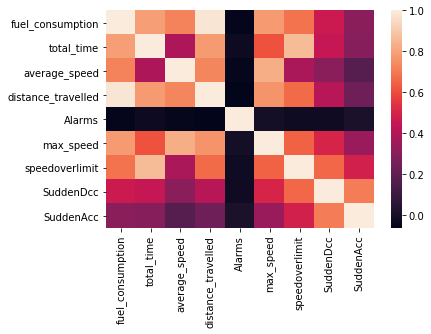

In [22]:
sns.heatmap(trip_df_c1.corr())

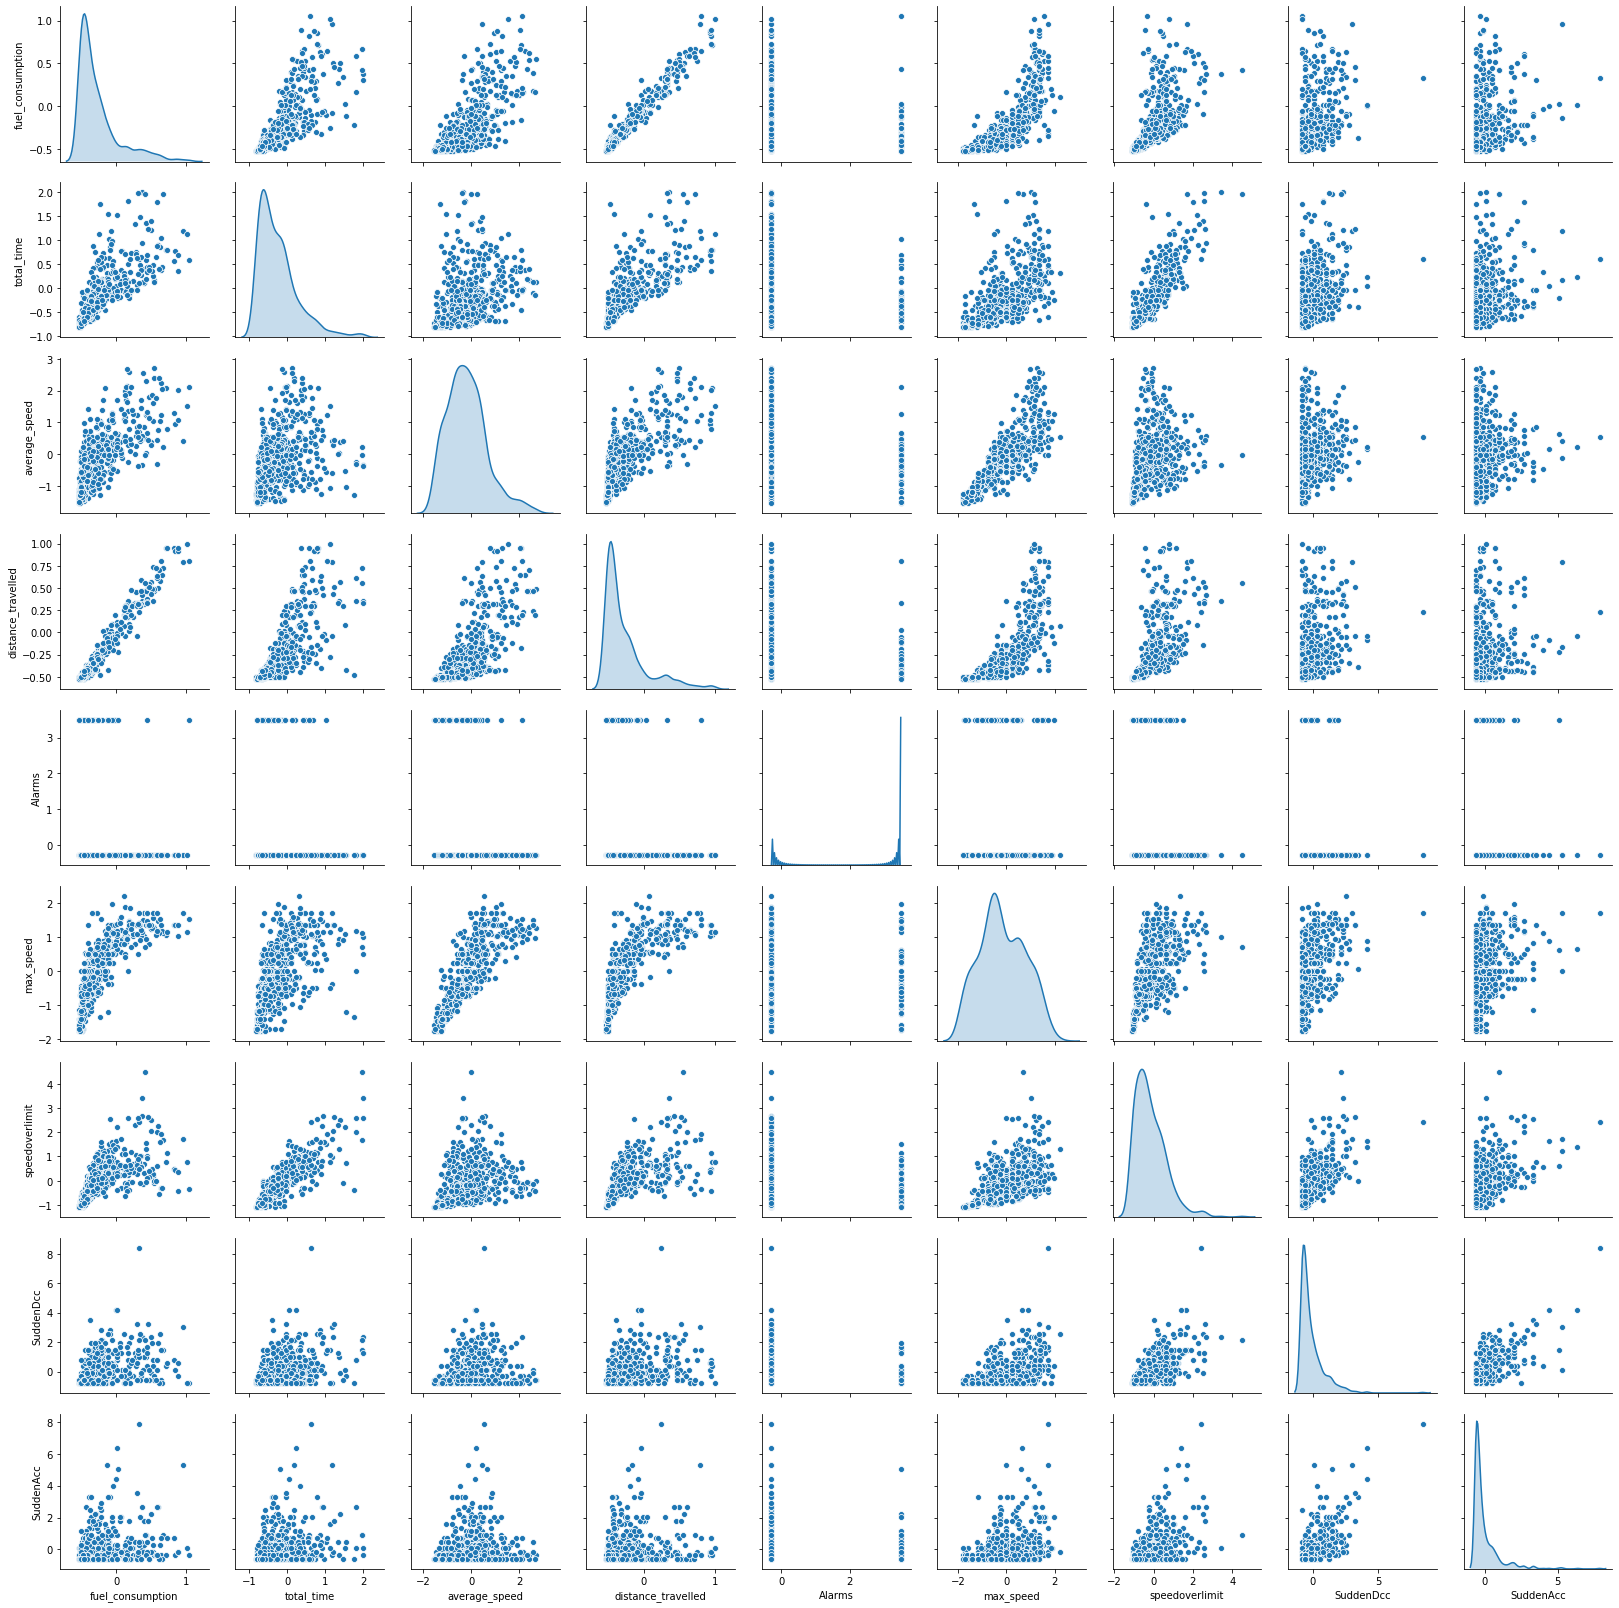

In [23]:
sns.pairplot(trip_df_c1, diag_kind='kde')   # to plot density curve instead of histogram


### Inferences :
1) Correlations
    - From the correlation matrix we can see that columns have correlation with one another 
    - fuel_consumption - distance_travelled - total_time have very high correlation with one another, the pair-plot shows clear positive correlation between these features
    - Alarms column seems to be an independent field with not much correlation with other fields.
    
2) Clusters
    - Along the max_speed dimension we can see 3 clusters, similarly we can see clusters vaguely along other dimensions too. Hence, the minimum number clusters to be formed in this dataset is 3. Pair-plots are not clearly giving us an idea of how many clusters can be formed here. 
    
3) Outliers
    - We can see few outlier clusters in the data, whose fuel_consumption, total_time, distance_travelled, speedoverlimit and SuddenAcc is much higher than other trips. They are visible in pair plots also.


### Let me apply K-means clustering to this data and check the inertia for each cluster.

In [24]:
cluster_range = range( 1, 10)   
cluster_errors = []
cluster_sil_scores = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init = 5)
    clusters.fit(trip_df_c1)
    labels = clusters.labels_                     # capture the cluster lables
    centroids = clusters.cluster_centers_         # capture the centroids
    cluster_errors.append( clusters.inertia_ )    # intertia(SSE - Loss function) 

#combine the cluster_range and cluster_errors into a dataframe by combining them    
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:15]

,num_clusters,cluster_errors
0,1,3547.559867
1,2,2417.253399
2,3,2006.752277
3,4,1395.601667
4,5,1214.019391
5,6,1075.254385
6,7,966.198120
7,8,887.698886
8,9,819.787767


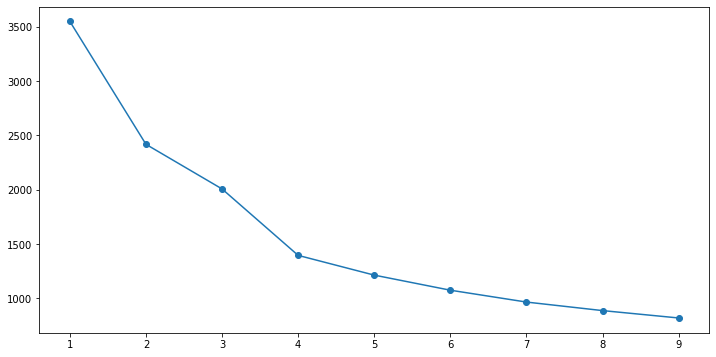

In [25]:
#As expected, clearly the inertia decreases as the number of clusters increase, but to what extent?
# plotting the errors - Elbow plot

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

#### But, as we can see, the elbow method doesnot provide us a clear exact point where the error reduction is diminishing. Maybe 4 or 5 or greater. We are not sure of the value of k through elbow method as the curve is smooth.
### Trying to find optimum value of k
#### So let us do Box and Whisker plot analysis. With these, we might be able to find optimum value of k and also meaning behind the clusters.

In [26]:
#Let us start from k =2.
kmeans=KMeans(2)
kmeans.fit(trip_df_c1)
prediction=kmeans.predict(trip_df_c1)
 
colnames = ['fuel_consumption','total_time','average_speed','distance_travelled','Alarms','max_speed','speedoverlimit','SuddenDcc','SuddenAcc']
trip_df2 = pd.DataFrame(trip_df_c1, columns= colnames)
trip_df2["Cluster_Num"] = prediction

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F93FD2FC88>,
      dtype=object)

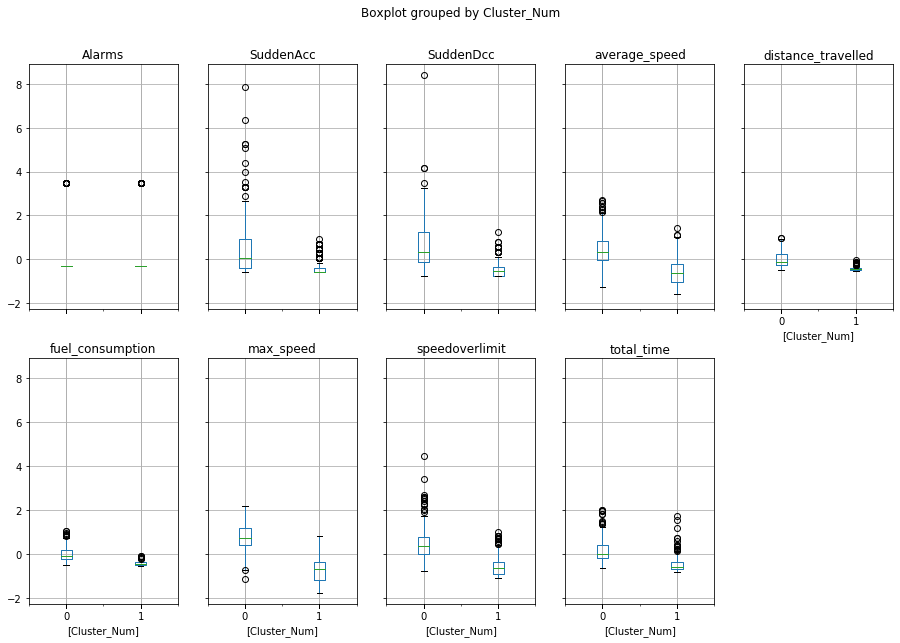

In [27]:
trip_df2.boxplot(by = 'Cluster_Num',  layout=(2,5), figsize=(15, 10))

# Insight with two clusters :
- Number of cases in Cluster 1 & 2 are more or less same.
- Cluster1 are those trips where drivers are driving faster, there max_speed and average_speed is higher than Cluster2 trips, hence distance travelled is also high, and so is fuel_consumption
- Also, Cluster1 have all the outlier values of SuddenAcc. It indicates that Cluster1 drivers are driving fast on an average, speeding over limit, also applying brakes suddenly and accelarating suddenly. We can in short say they are unsafe drivers.    
Let me make 3 clusters.


In [28]:
#Let us start from k = 3.
kmeans_final=KMeans(3)
kmeans_final.fit(trip_df_c1)
prediction=kmeans_final.predict(trip_df_c1)
 
colnames = ['fuel_consumption','total_time','average_speed','distance_travelled','Alarms','max_speed','speedoverlimit','SuddenDcc','SuddenAcc']
trip_df3 = pd.DataFrame(trip_df_c1, columns= colnames)
trip_df3["Cluster_Num"] = prediction

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F94152A0F0>,
      dtype=object)

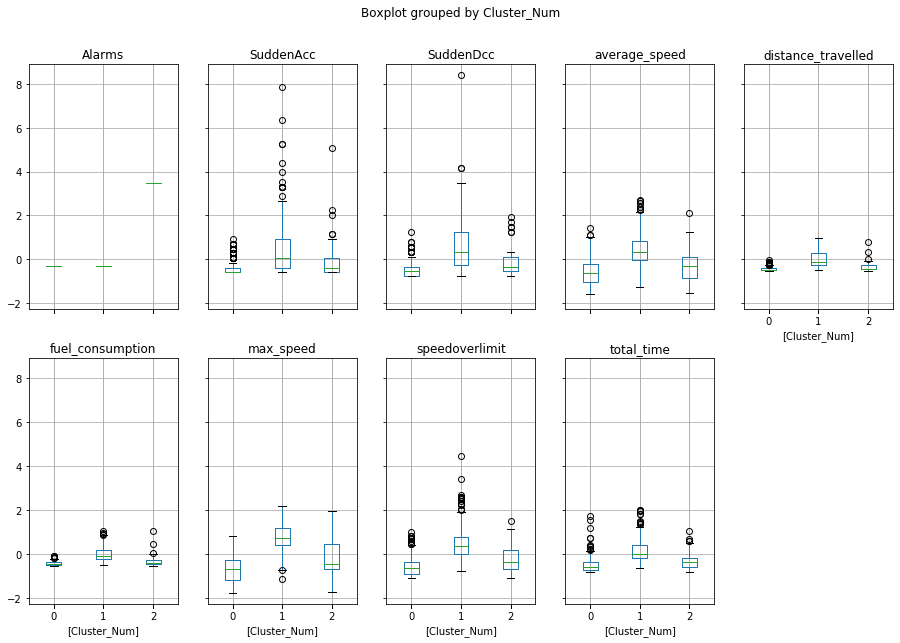

In [29]:
trip_df3.boxplot(by = 'Cluster_Num',  layout=(2,5), figsize=(15, 10))

### Insight with three clusters :
- Not much overlapping is happening here in 3 clusters (which is good), there is a clear seperation in clusters.
- Cluster 1 are slow drivers, they take more shorter trips.

- Cluster 2 are fast unsafe drivers, on a average they do cover more distance but marginally. It might be inferred that they are trying to cover more and more distance in less amount of time to earn more money, since they are driving for more time. Also they seem to deliberetly take more longer trips.

- Cluster 3 are average drivers, they take average amount of trips, apply sudden accelaration sometimes. They also drive safely.

3 clusters seem to be optimum for this problem set, but let us create four clusters and analyse.


In [30]:
#Let us start from k = 4.
kmeans=KMeans(4)
kmeans.fit(trip_df_c1)
prediction=kmeans.predict(trip_df_c1)
 
colnames = ['fuel_consumption','total_time','average_speed','distance_travelled','Alarms','max_speed','speedoverlimit','SuddenDcc','SuddenAcc']
trip_df4 = pd.DataFrame(trip_df_c1, columns= colnames)
trip_df4["Cluster_Num"] = prediction

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F942F19198>,
      dtype=object)

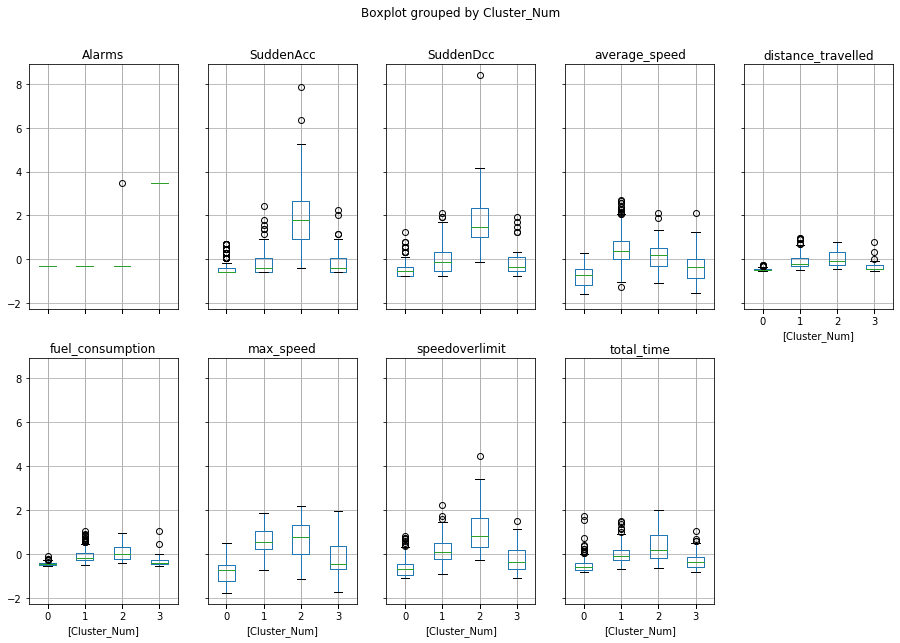

In [31]:
trip_df4.boxplot(by = 'Cluster_Num',  layout=(2,5), figsize=(15, 10))

### Insight with four clusters :
- There are a lot of overlapping between Cluster 3 and 4, clear definition of these clusters is difficult. Hence, 3 number of clusters are good enough.

### Now, let me recreate the original trip data with cluster numbers in them.

In [32]:
trip_df_pred = pd.merge(trip_df_orig, trip_df3['Cluster_Num'], how='left', left_index = True, right_index = True )

In [33]:
#Adding comments to three deleted Trips
trip_df_pred.loc[trip_df_pred['Trip_id']== 55, 'Cluster_Num'] = 'Datapoint not included in Clustering'
trip_df_pred.loc[trip_df_pred['Trip_id']== 174, 'Cluster_Num'] = 'Datapoint not included in Clustering'
trip_df_pred.loc[trip_df_pred['Trip_id']== 685, 'Cluster_Num'] = 'Datapoint not included in Clustering'

In [34]:
#Let us make the outlier Datapoints considered previously as Cluster : 3
trip_df_pred.loc[trip_df_pred['Cluster_Num'].isnull(), 'Cluster_Num'] = '3'

In [35]:
trip_df_pred.head(5)

,Trip_id,fuel_consumption,total_time,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc,Cluster_Num
0,1,1.633,00:43:37,30.494434,0,22676.0,0,118,184,4,1,1
1,2,0.284,00:14:10,18.058823,0,4000.0,0,60,77,3,1,0
2,3,0.088,00:02:33,18.087805,0,824.0,0,45,19,1,2,0
3,4,1.021,00:17:20,44.190735,0,13515.0,0,108,86,1,0,1
4,5,0.271,00:10:34,23.780981,0,4307.0,13,65,82,3,3,2


### Analysing the trip_df_c2 data
### Now we should analyse that what the Outlier Cluster i.e. Cluster 3 denote. Best way to analyse clusters of a 12 dimensional data is through boxplots.   
Let me quickly re-create the normalised data for box-plot analysis.

In [36]:
trip_df_fin = trip_df3.append(trip_df_c2)
trip_df_fin.reset_index(drop=True)
trip_df_fin.loc[trip_df_fin['Cluster_Num'].isnull(),'Cluster_Num'] = '3'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [37]:
trip_df_fin.tail(5)

,Alarms,Cluster_Num,SuddenAcc,SuddenDcc,average_speed,distance_travelled,fuel_consumption,max_speed,speedoverlimit,total_time
693,-0.286513,3,1.580356,1.461887,1.567892,1.461933,1.916546,2.197263,0.753437,1.026978
698,-0.286513,3,0.495152,0.790660,1.166810,1.358613,1.281815,1.340513,0.693466,0.939644
703,-0.286513,3,3.099641,1.909372,1.223212,1.952702,2.445801,1.952477,1.796936,1.722592
714,-0.286513,3,0.929234,1.461887,0.855647,1.616913,1.421448,1.340513,1.293178,1.393412
716,-0.286513,3,1.146274,1.014402,1.461448,1.565253,1.627144,1.340513,0.225690,1.150955


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F943AD3748>,
      dtype=object)

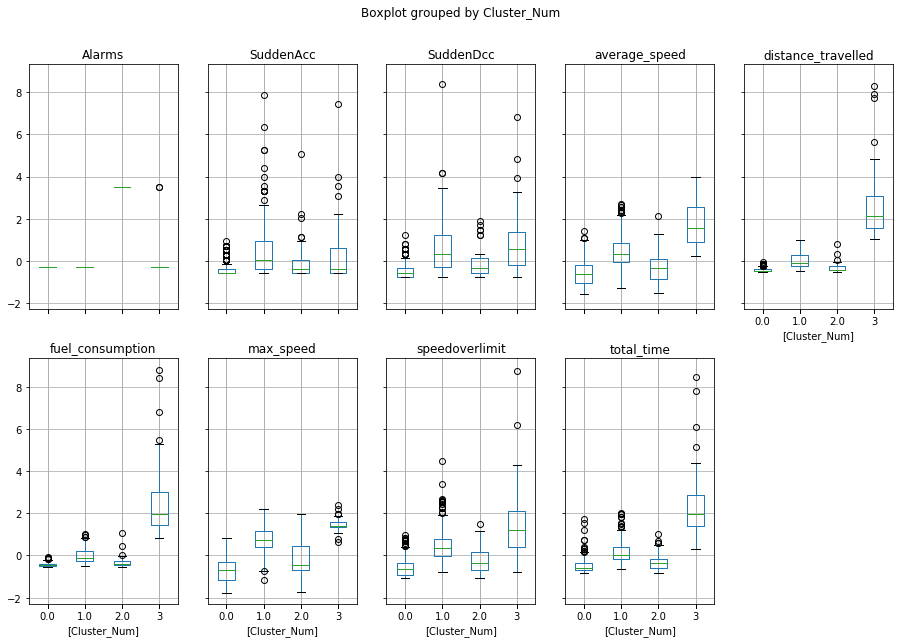

In [38]:
trip_df_fin.boxplot(by = 'Cluster_Num',  layout=(2,5), figsize=(15, 10))

## Final Inferencing of Clusters :
Not much overlapping is happening here in these clusters, across features(which is good), there is a clear seperation in clusters. Except SuddenAcc and SuddenDcc field. A reason for this may be that many drivers have similar manner of driving, or it is because they are driving on similar roads.
Now, let me infer what trips of Clusters are meaning :     
    
Cluster 0 are slow drivers, they take more shorter trips, hence consuming less fuel. There max_speed is also on the lower side and cases of speedoverlimit are less. We may infer that they are new drivers or are simply over carefull while driving and are not concerned about covering large distances while driving.

Cluster 1 are fast unsafe drivers, on a average they do cover more distance but marginally, It might be inferred that they are driving fast to cover more distance in less amount of time as their max_speed and speedoverlimit is high. They are also driving more time maybe to earn bonus from extra driving. Also, their pattern driving is unpredictable as the SuddenAcc and SuddenDcc is spreaded in a high range, maybe because they are frustrated with driving in traffic areas.

Cluster 2 are average drivers, they take average amount of trips, apply sudden accelaration sometimes. Smaller trips than Cluster 1 but larger trips than Cluster 0. They also drive safely.      
P.S. One important thing to notice is that for some reason this cluster's drivers are getting high Alarm. But it might be a glitch in the Data collection as only 0 and 13 values are present in the entire data. And Cluster 1 trips are not getting any alarms. Domain experts should look into this matter.

Cluster 3, the outlier clusters is clearly different kind of trips from all the other trips. These trips seem to be Outstation rides. As these trips are of longer duration covering large distances and consuming more fuel. Averagespeed and Maxspeed are high of these trips and many a times they go speed over limit, maybe because they drive on highways, on a less traffic area. Irrespective of outstation rides, these drivers are donot have a very high rate of SuddenAcc and SuddenDcc.It means they are somewhat safe drivers.

I will be scoring this dataset on a scale of small - long trips, 1 being small trips to 4 being larger outstation trips.    
Hence, I will rename Clusters as :    
0 : Cluster 1 : Small Trips    
1 : Cluster 3 : Long Trips     
2 : Cluster 2 : Average Trips      
3 : Cluster 4 : Outstation Trips   

### Let me rename clusters in our final file here :

In [39]:
trip_df_pred['Cluster_Num'].unique()

array([1.0, 0.0, 2.0, '3', 'Datapoint not included in Clustering'],
      dtype=object)

In [40]:
trip_df_pred.loc[trip_df_pred['Cluster_Num'] == 0.0, 'Cluster_Num'] = 'Cluster 1 : Small Trips'
trip_df_pred.loc[trip_df_pred['Cluster_Num'] == 1.0, 'Cluster_Num'] = 'Cluster 3 : Long Trips'
trip_df_pred.loc[trip_df_pred['Cluster_Num'] == 2.0, 'Cluster_Num'] = 'Cluster 2 : Average Trips'
trip_df_pred.loc[trip_df_pred['Cluster_Num'] == '3', 'Cluster_Num'] = 'Cluster 4 : Outstation Trips'

In [43]:
trip_df_pred.tail(5)

,Trip_id,fuel_consumption,total_time,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc,Cluster_Num
723,724,0.296,00:05:59,24.893618,0,4000.0,0,52,29,3,0,Cluster 1 : Small Trips
724,725,0.171,00:03:49,53.956800,0,3747.0,0,72,16,1,0,Cluster 1 : Small Trips
725,726,1.355,00:31:14,32.827724,0,17499.0,0,111,199,10,8,Cluster 3 : Long Trips
726,727,0.726,00:38:02,13.623775,0,8723.0,13,55,161,1,0,Cluster 2 : Average Trips
727,728,0.878,00:15:50,46.730840,0,12838.0,0,90,102,4,7,Cluster 3 : Long Trips


In [42]:
#Saving this dataframe to csv at cwd: 
trip_df_pred.to_csv('triproute_predictions.csv', index=False, header=True)


### Let me try to visualise the clusters using only 2 features for visualisation purpose.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


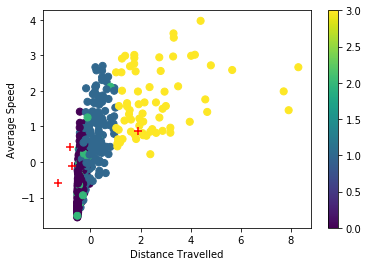

In [50]:
x = trip_df_fin['distance_travelled'] 
y = trip_df_fin['average_speed'] 
Cluster = trip_df_fin['Cluster_Num'] 
centers = np.random.randn(4, 2) 

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=50)
for i,j in centers:
    ax.scatter(i,j,s=50,c='red',marker='+')
ax.set_xlabel('Distance Travelled')
ax.set_ylabel('Average Speed')
plt.colorbar(scatter)

fig.show()
